Data Description

In this competition, you will predict the probability that an auto insurance policy holder files a claim.

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

File descriptions

* train.csv contains the training data, where each row corresponds to a policy holder, and the target columns signifies that a claim was filed.
* test.csv contains the test data.
* sample_submission.csv is submission file showing the correct format.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

**LOAD THE DATA**

In [2]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")
df_train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


**Basic**

In [3]:
df_train.dtypes

id                  int64
target              int64
ps_ind_01           int64
ps_ind_02_cat       int64
ps_ind_03           int64
ps_ind_04_cat       int64
ps_ind_05_cat       int64
ps_ind_06_bin       int64
ps_ind_07_bin       int64
ps_ind_08_bin       int64
ps_ind_09_bin       int64
ps_ind_10_bin       int64
ps_ind_11_bin       int64
ps_ind_12_bin       int64
ps_ind_13_bin       int64
ps_ind_14           int64
ps_ind_15           int64
ps_ind_16_bin       int64
ps_ind_17_bin       int64
ps_ind_18_bin       int64
ps_reg_01         float64
ps_reg_02         float64
ps_reg_03         float64
ps_car_01_cat       int64
ps_car_02_cat       int64
ps_car_03_cat       int64
ps_car_04_cat       int64
ps_car_05_cat       int64
ps_car_06_cat       int64
ps_car_07_cat       int64
ps_car_08_cat       int64
ps_car_09_cat       int64
ps_car_10_cat       int64
ps_car_11_cat       int64
ps_car_11           int64
ps_car_12         float64
ps_car_13         float64
ps_car_14         float64
ps_car_15   

In [4]:
# Obtain feature columns in a list
features = []
bin_features = []
cat_features = []
other_features = []
for c in df_train.columns:
    if (c != 'id') and (c != 'target'):
        features.append(c)
        if 'bin' in c:
            bin_features.append(c)
        elif 'cat' in c:
            cat_features.append(c)
        else:
            other_features.append(c)

In [5]:
print(len(df_train))
print(len(df_train.id.unique()))

595212
595212


We see that every user/customer has a unique data point, so there is no sequential data

**Check nulls**

In [6]:
print(df_train.isnull().sum().sum())
print(df_test.isnull().sum().sum())

0
0


There is no Nulls, but as the data description says, -1 represents nulls. Let's see how many of them we have per column:

C:\Program Files\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



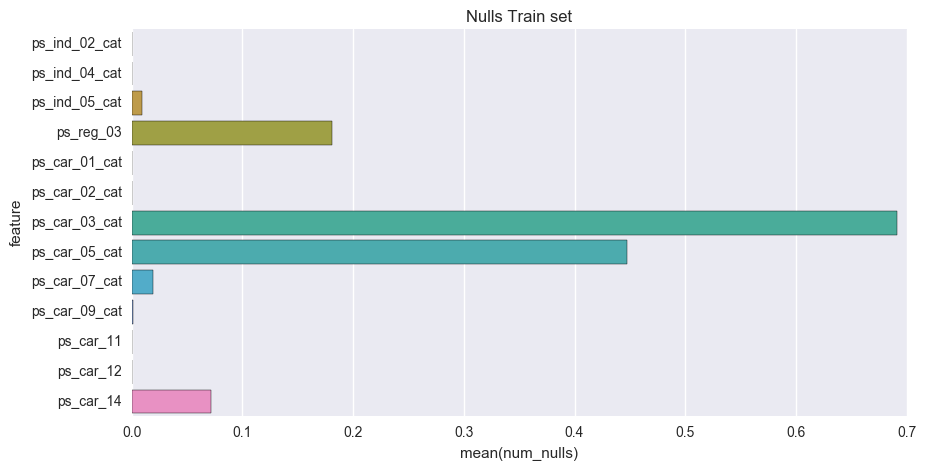

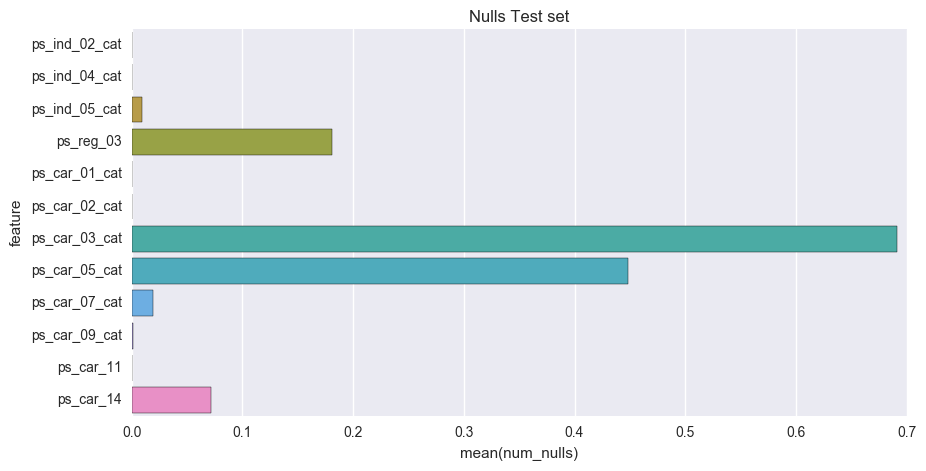

In [7]:
plt.rcParams['figure.figsize']=(10,5)

train_null_columns = []
train_num_nulls = []
for c in df_train.columns:
    null_rows = df_train[df_train[c] == -1]
    if len(null_rows) > 0:
        train_null_columns.append(c)
        train_num_nulls.append(len(null_rows)/len(df_train))
        
test_null_columns = []
test_num_nulls = []
for c in df_test.columns:
    null_rows = df_test[df_test[c] == -1]
    if len(null_rows) > 0:
        test_null_columns.append(c)
        test_num_nulls.append(len(null_rows)/len(df_test))
        
df_train_nulls = pd.DataFrame(columns=['feature', 'num_nulls'])
df_train_nulls['feature'] = train_null_columns
df_train_nulls['num_nulls'] = train_num_nulls
df_train_nulls.head()
ax = sns.barplot(x="num_nulls", y="feature", data=df_train_nulls)
plt.title('Nulls Train set')
plt.show()


df_test_nulls = pd.DataFrame(columns=['feature', 'num_nulls'])
df_test_nulls['feature'] = test_null_columns
df_test_nulls['num_nulls'] = test_num_nulls
df_test_nulls.head()
ax = sns.barplot(x="num_nulls", y="feature", data=df_test_nulls)
plt.title('Nulls Test set')
plt.show()

We observe that there are some features with a high number of nulls, like ps_car_03_cat, ps_car_05_cat, ps_reg_03, ps_car_14
We will need to deal with these nulls.
Also we check that nulls are not present in binary features

**Analyze binary feature values****

ps_ind_06_bin


C:\Program Files\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



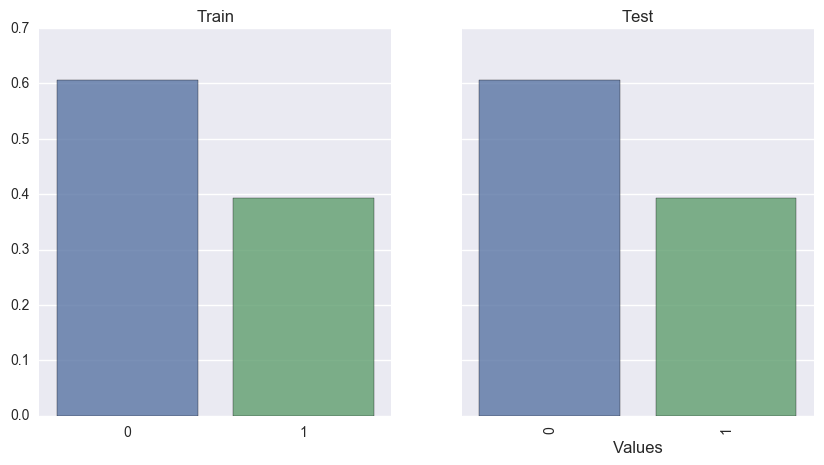

ps_ind_07_bin


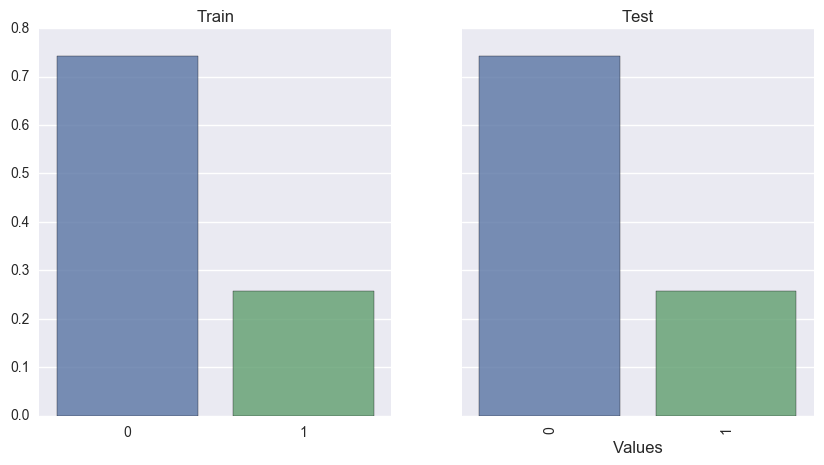

ps_ind_08_bin


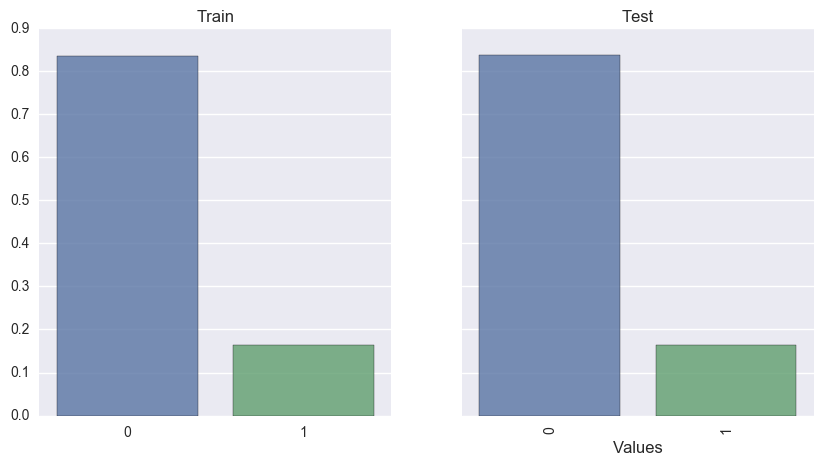

ps_ind_09_bin


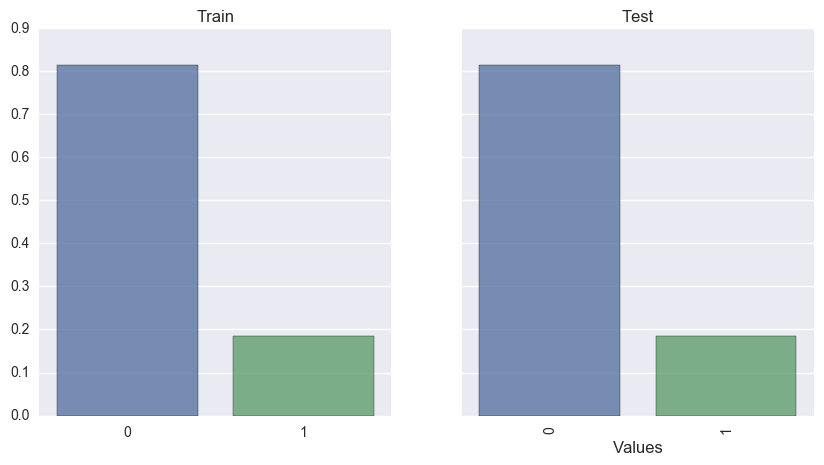

ps_ind_10_bin


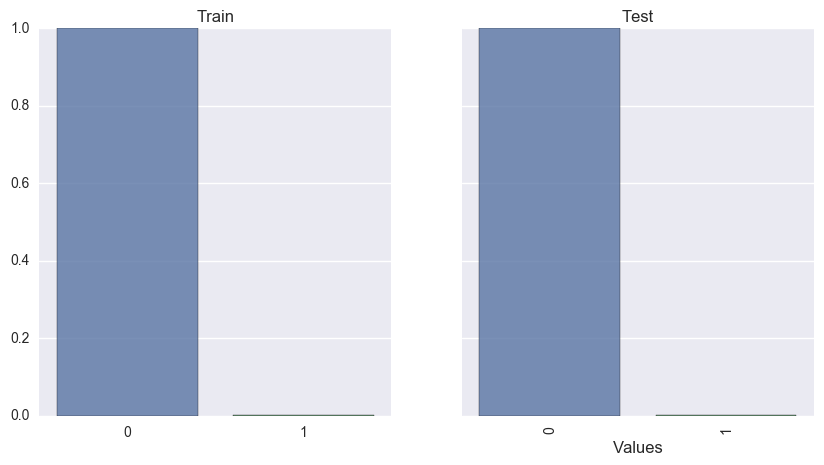

ps_ind_11_bin


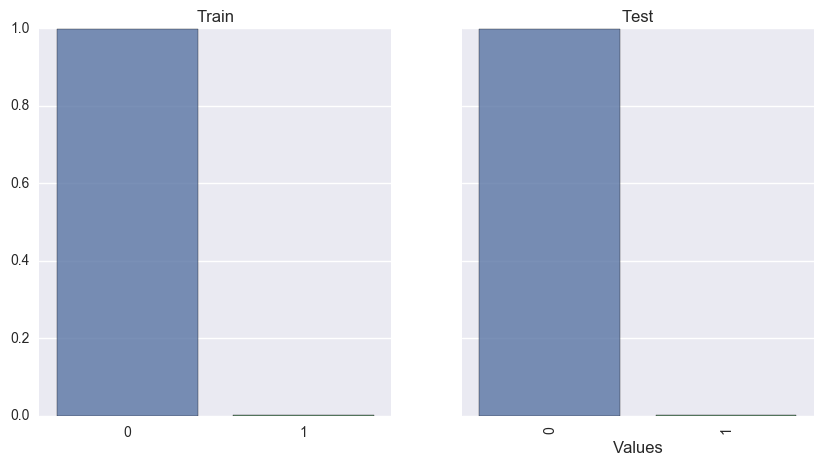

ps_ind_12_bin


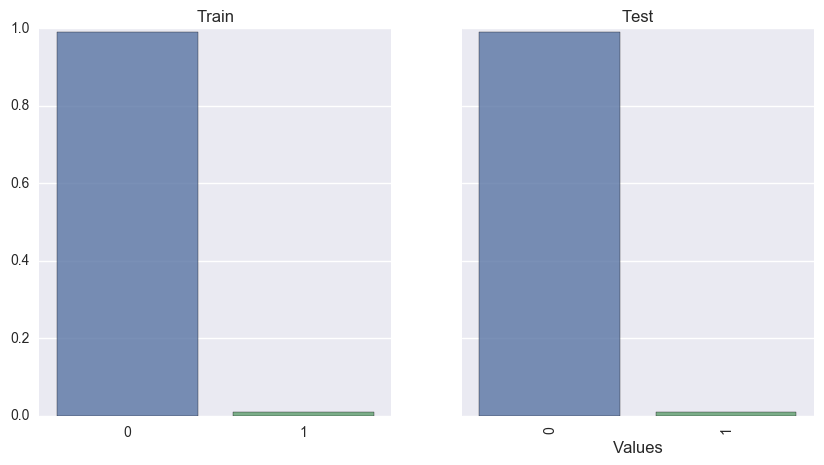

ps_ind_13_bin


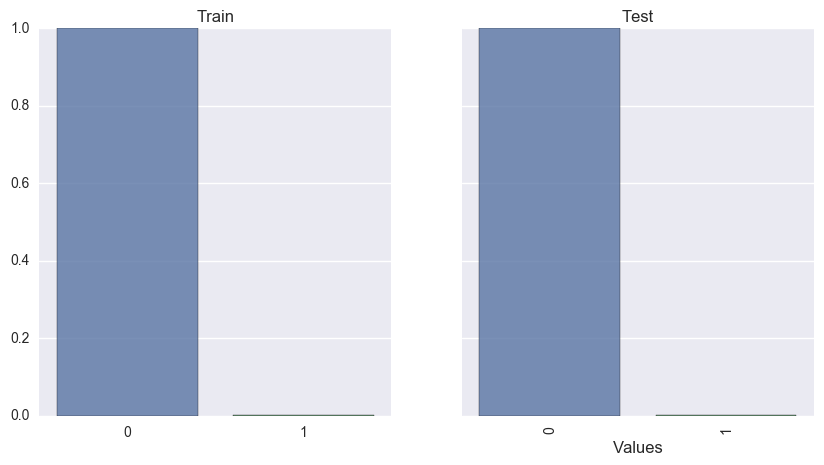

ps_ind_16_bin


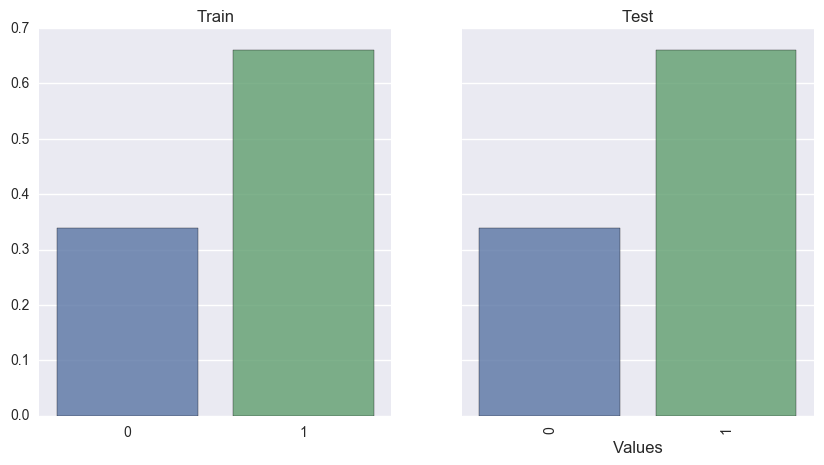

ps_ind_17_bin


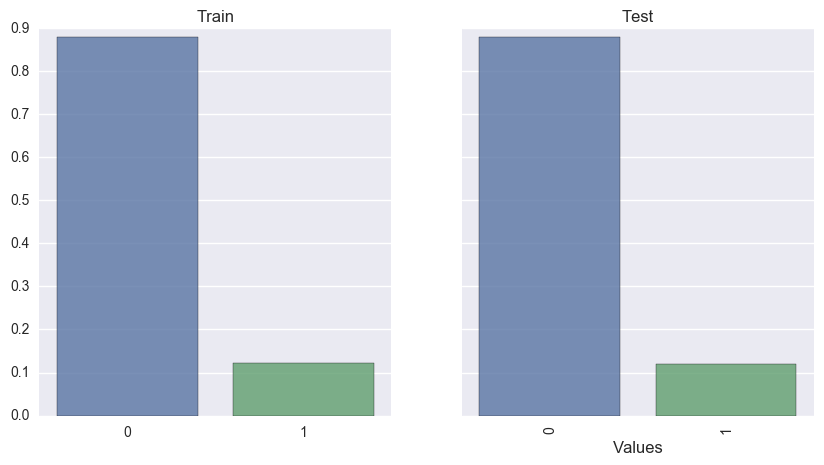

ps_ind_18_bin


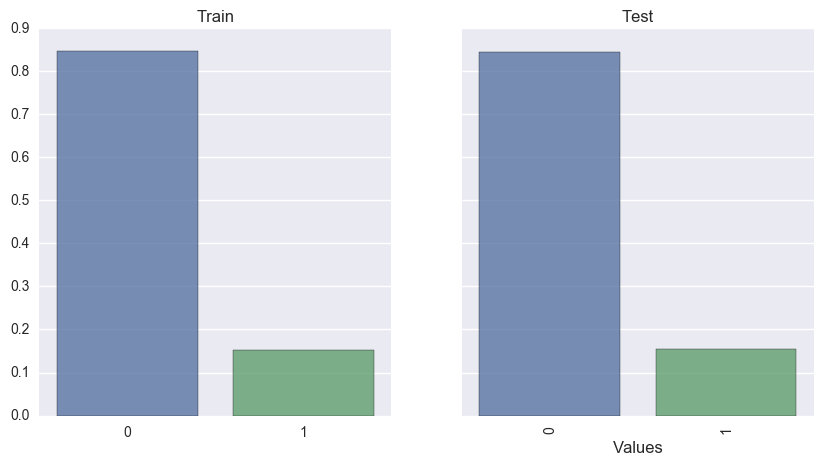

ps_calc_15_bin


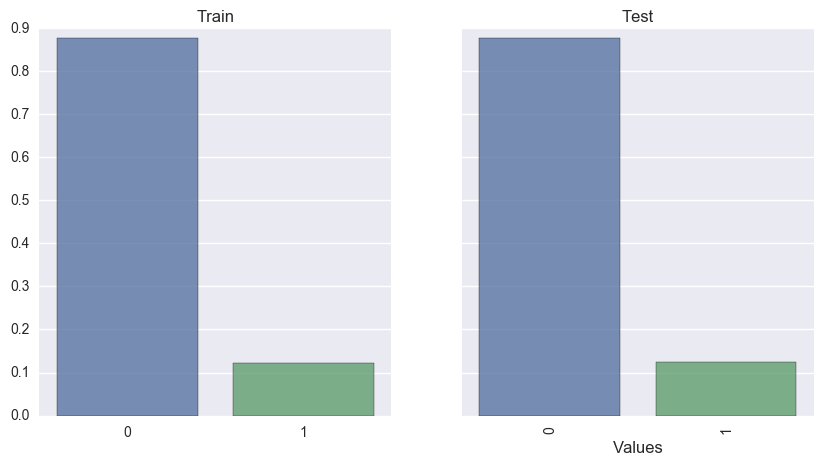

ps_calc_16_bin


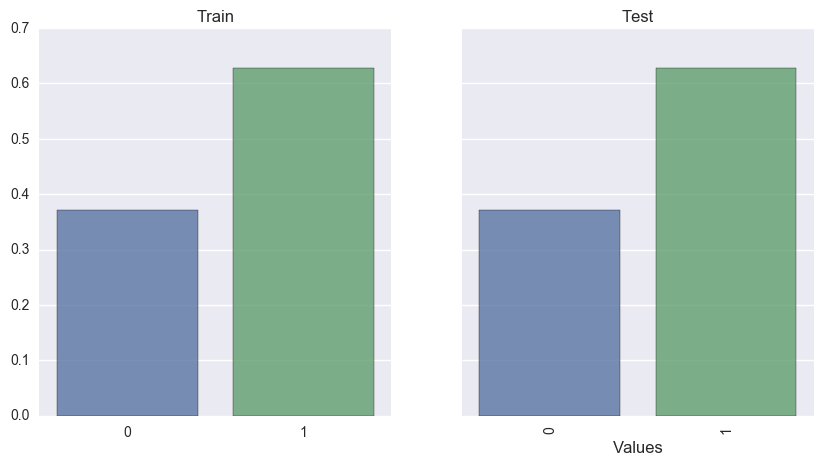

ps_calc_17_bin


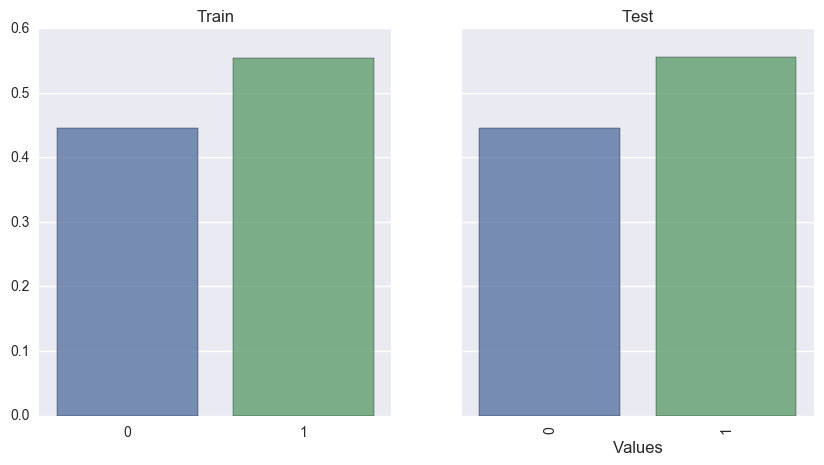

ps_calc_18_bin


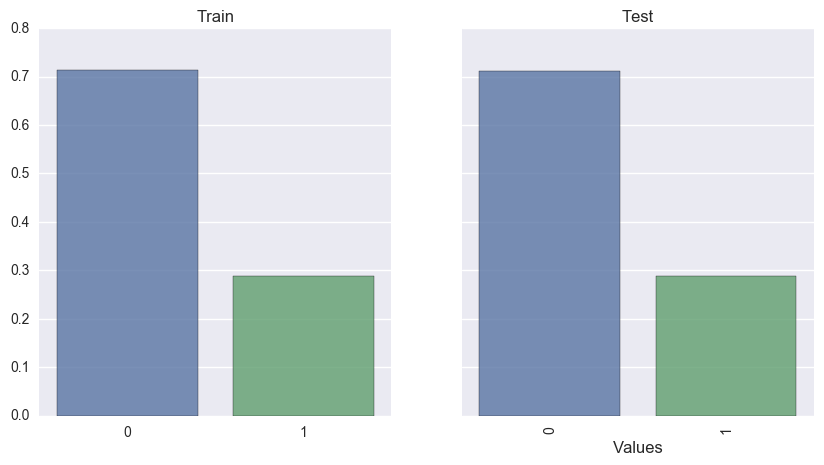

ps_calc_19_bin


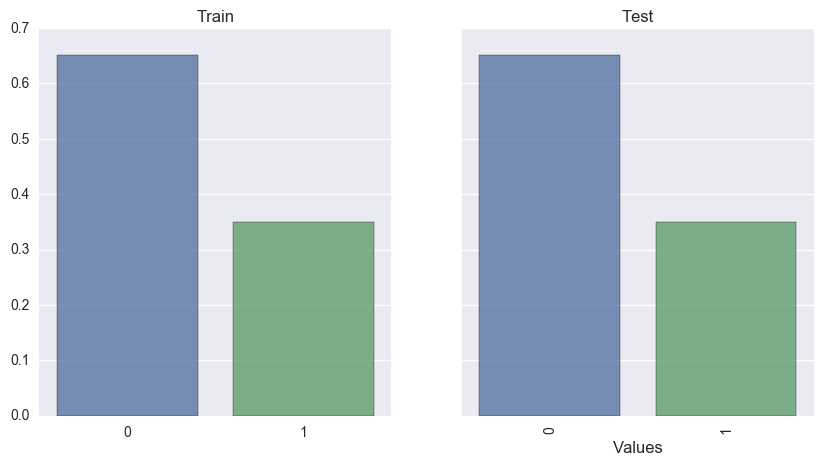

ps_calc_20_bin


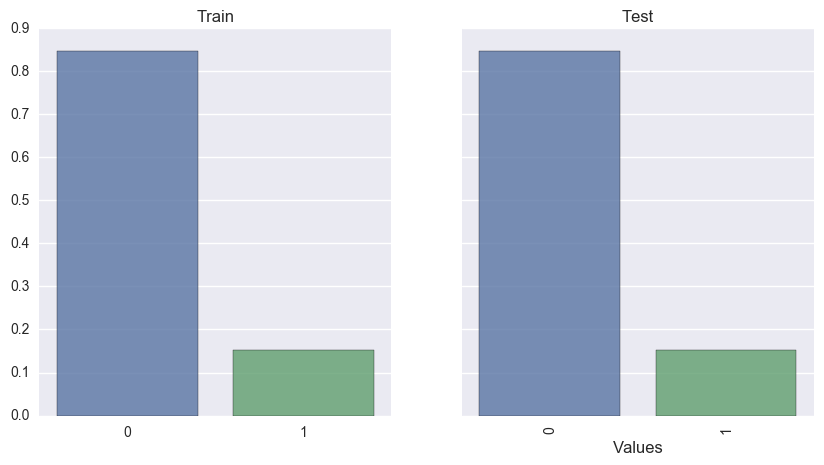

In [8]:
for c in bin_features:
    print(c)
    value_counts_train = df_train[c].value_counts()/df_train[c].value_counts().sum()
    value_counts_test = df_test[c].value_counts()/df_test[c].value_counts().sum()
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    #plt.figure(figsize=(5,5))
    sns.barplot(value_counts_train.index, value_counts_train.values, alpha=0.8, ax=ax1)
    sns.barplot(value_counts_test.index, value_counts_test.values, alpha=0.8, ax=ax2)
    #plt.ylabel('Number of Occurrences ' + c, fontsize=12)
    ax1.set_title('Train')
    ax2.set_title('Test')
    plt.xlabel('Values', fontsize=12)
    plt.xticks(rotation='vertical')
    plt.show()

**Analyze categorical features**

ps_ind_02_cat


C:\Program Files\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



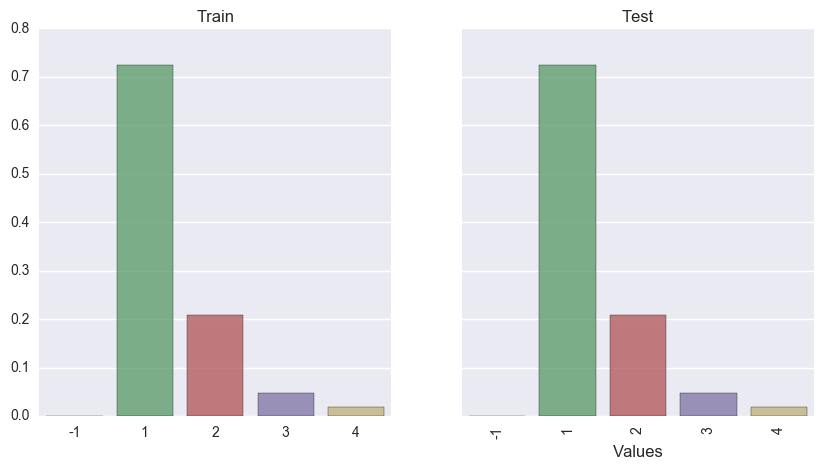

ps_ind_04_cat


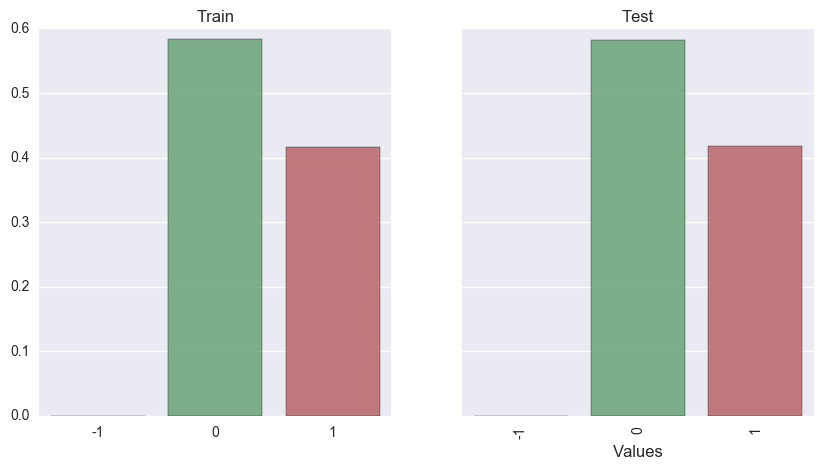

ps_ind_05_cat


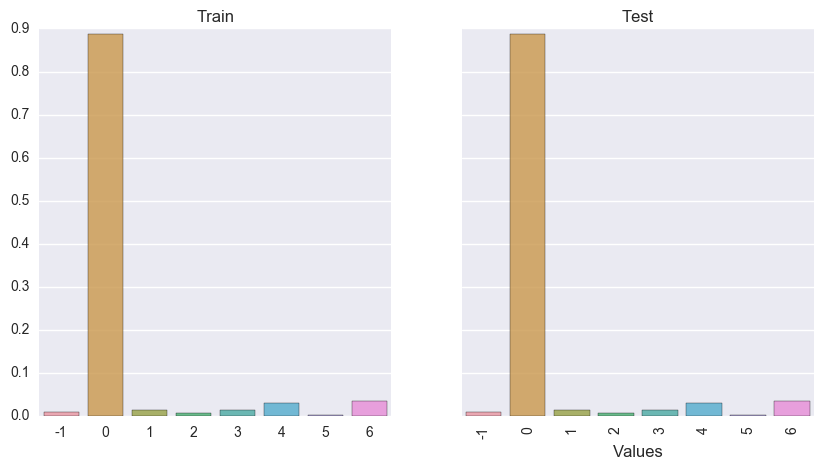

ps_car_01_cat


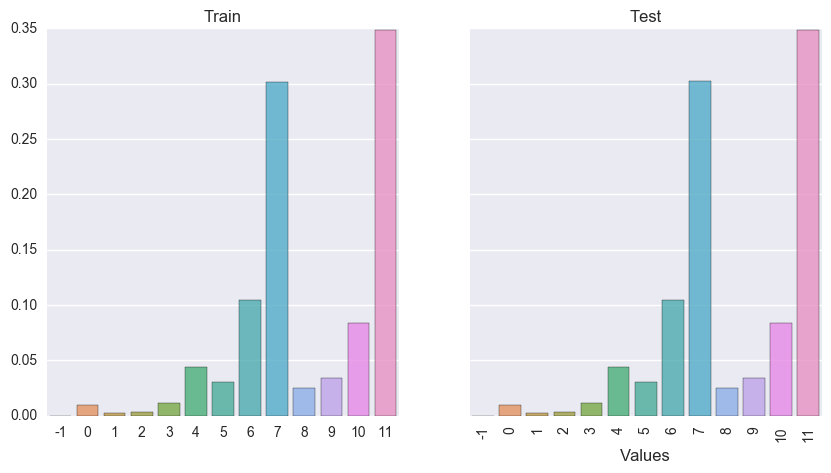

ps_car_02_cat


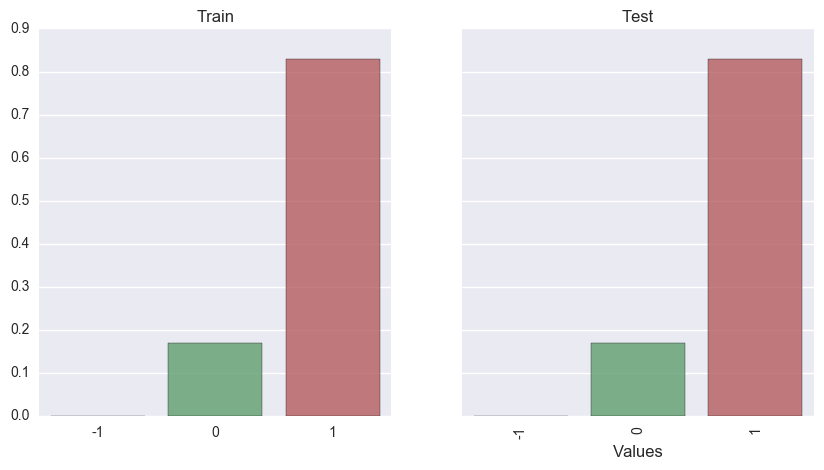

ps_car_03_cat


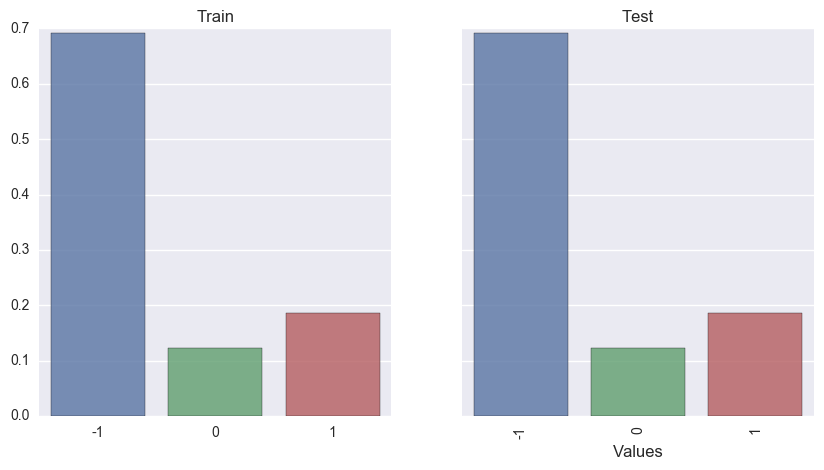

ps_car_04_cat


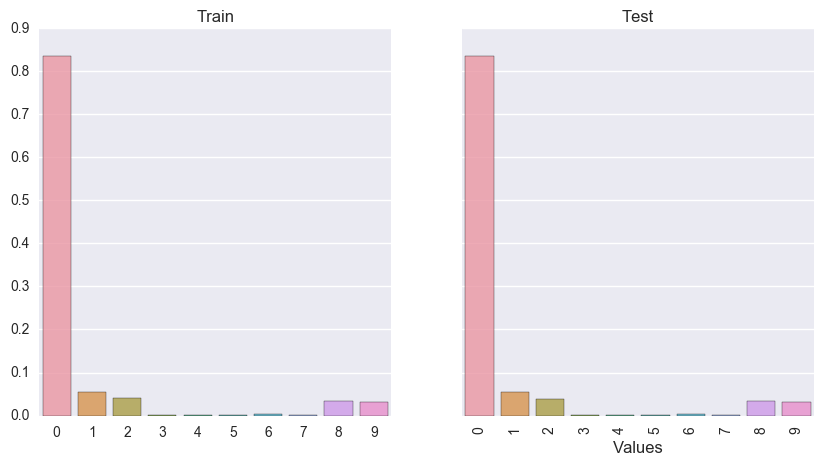

ps_car_05_cat


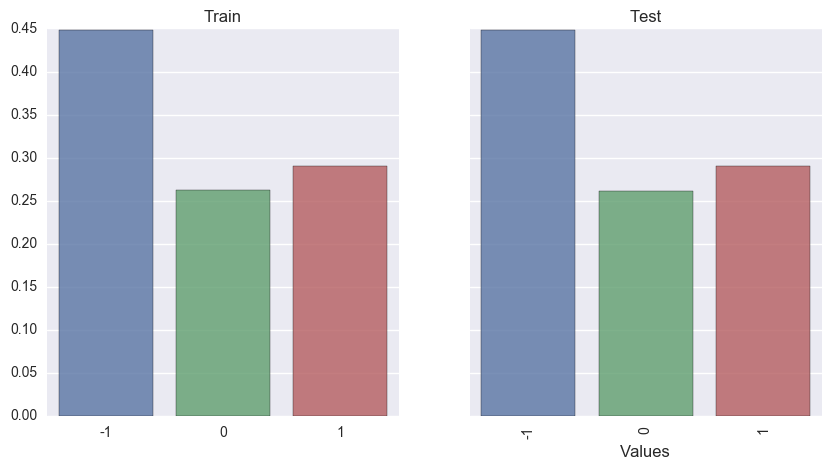

ps_car_06_cat


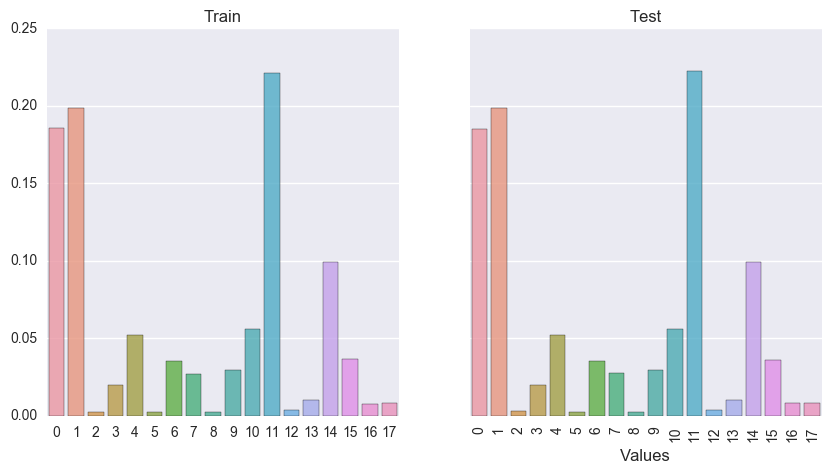

ps_car_07_cat


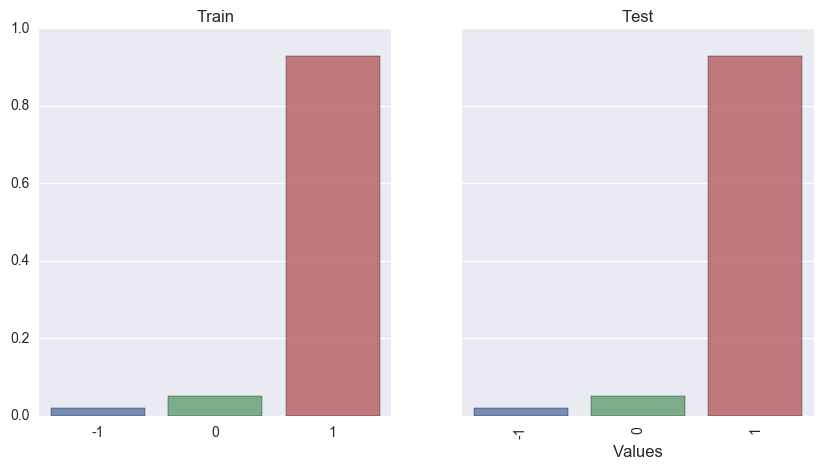

ps_car_08_cat


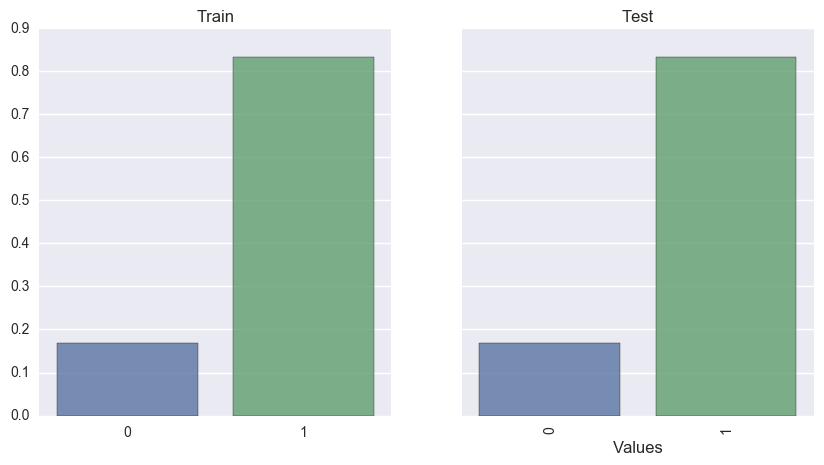

ps_car_09_cat


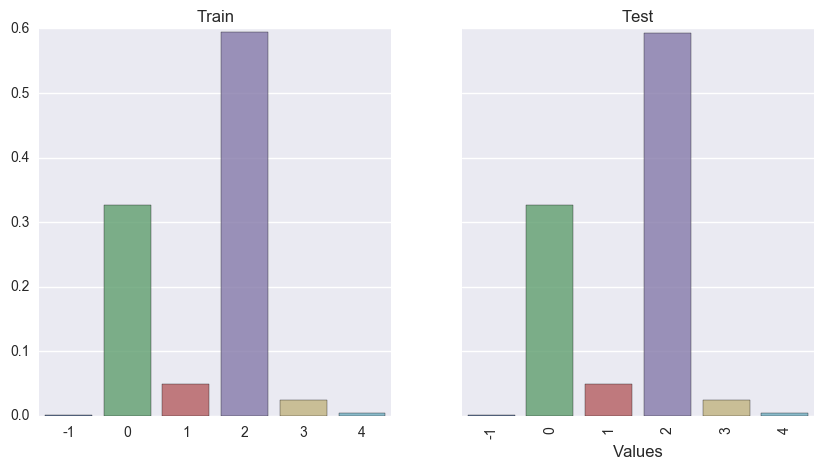

ps_car_10_cat


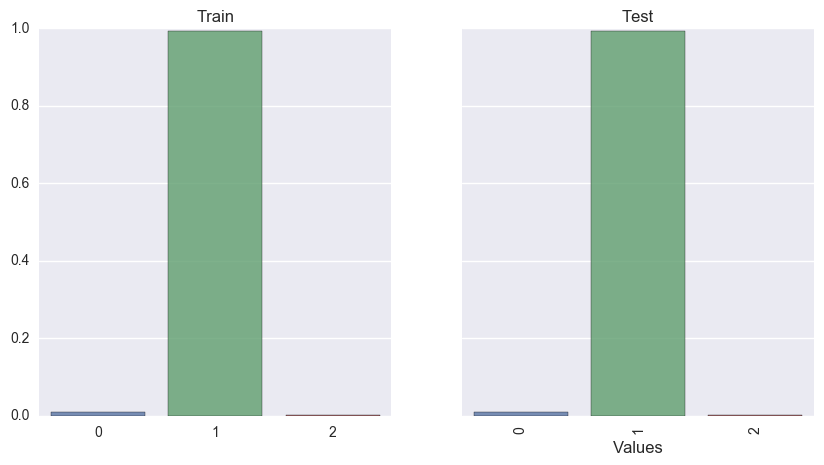

ps_car_11_cat


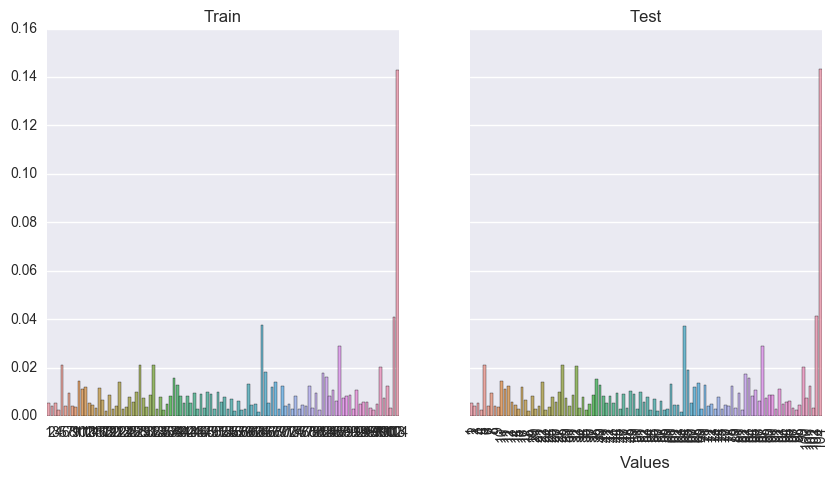

In [9]:
for c in cat_features:
    print(c)
    value_counts_train = df_train[c].value_counts()/df_train[c].value_counts().sum()
    value_counts_test = df_test[c].value_counts()/df_test[c].value_counts().sum()
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    #plt.figure(figsize=(5,5))
    sns.barplot(value_counts_train.index, value_counts_train.values, alpha=0.8, ax=ax1)
    sns.barplot(value_counts_test.index, value_counts_test.values, alpha=0.8, ax=ax2)
    #plt.ylabel('Number of Occurrences ' + c, fontsize=12)
    ax1.set_title('Train')
    ax2.set_title('Test')
    plt.xlabel('Values', fontsize=12)
    plt.xticks(rotation='vertical')
    plt.show()

Feature ps_car_11_cat contains many categories

**Analyze numerical features**

In [10]:
num_float = df_train.select_dtypes(include=['float64']).columns
num_int = df_train.select_dtypes(include=['int64']).columns

First ordinal features

ps_ind_01


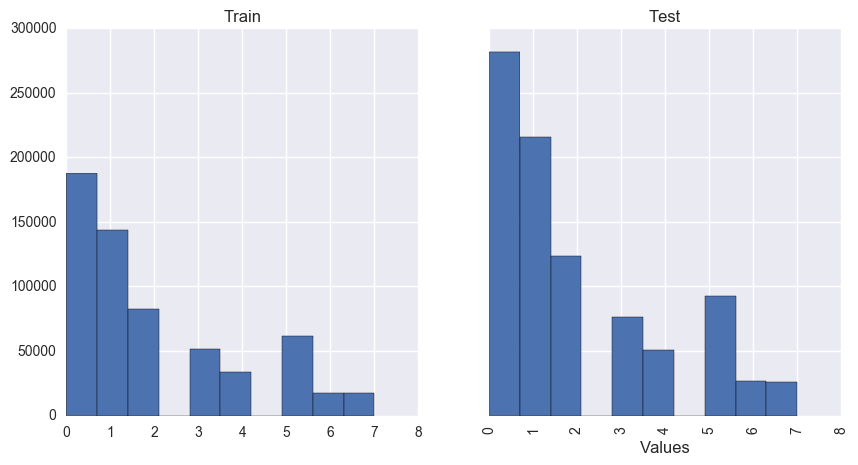

ps_ind_03


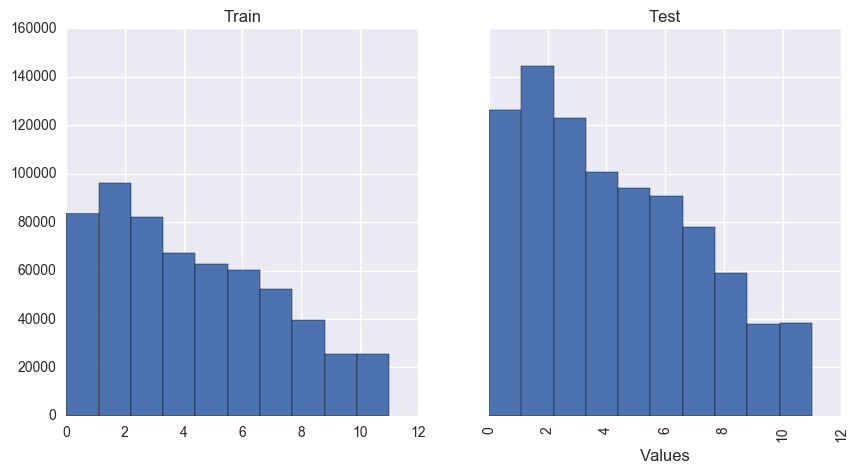

ps_ind_14


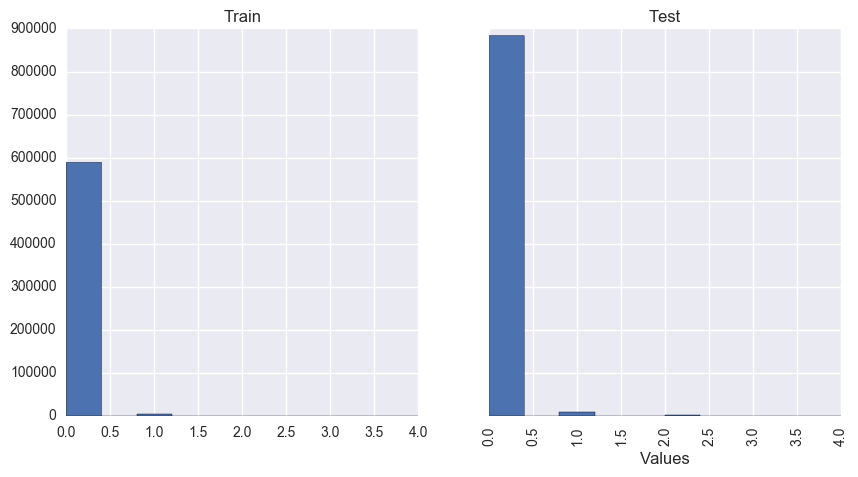

ps_ind_15


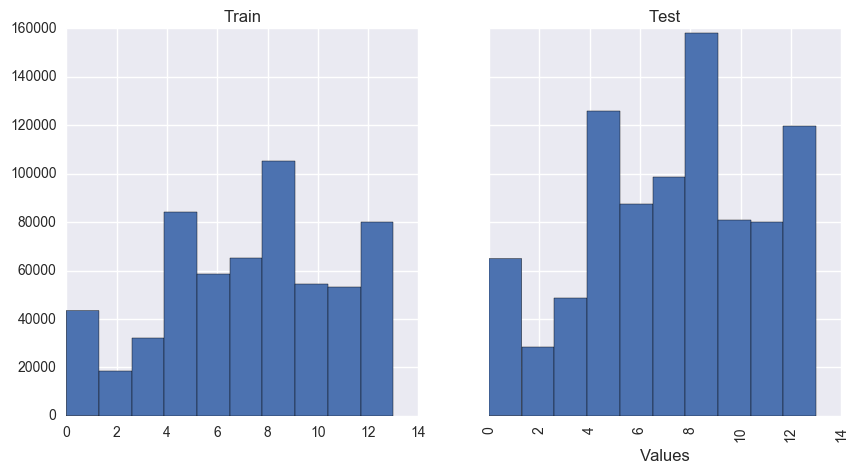

ps_car_11


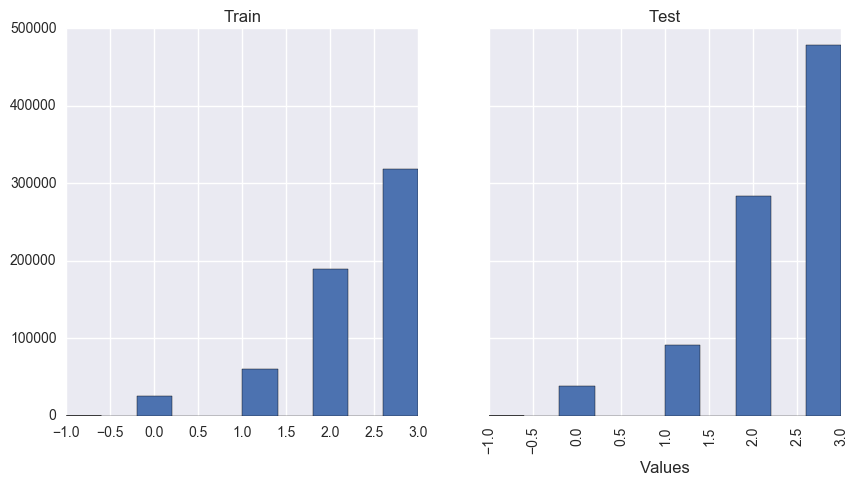

ps_calc_04


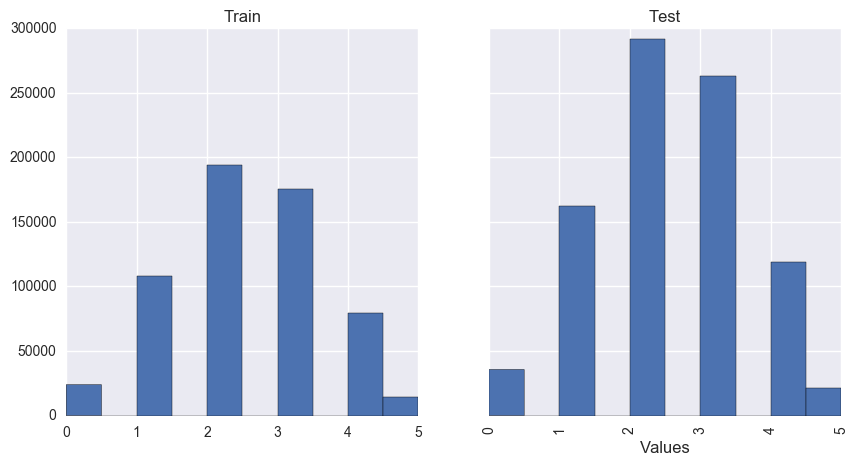

ps_calc_05


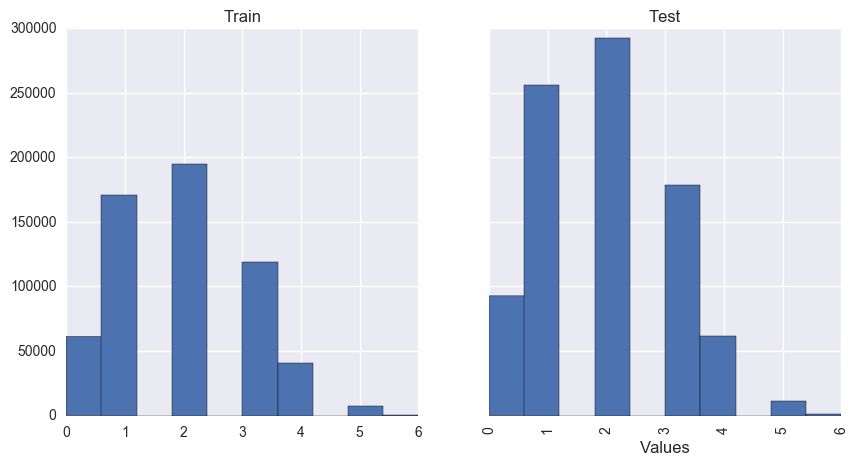

ps_calc_06


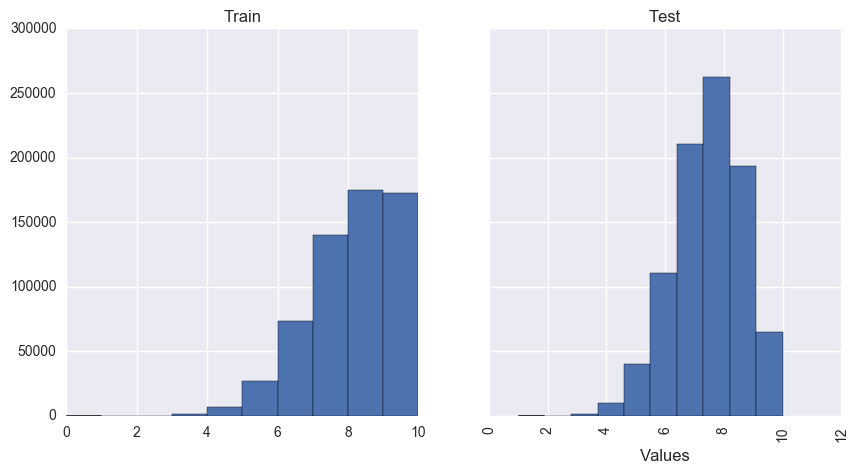

ps_calc_07


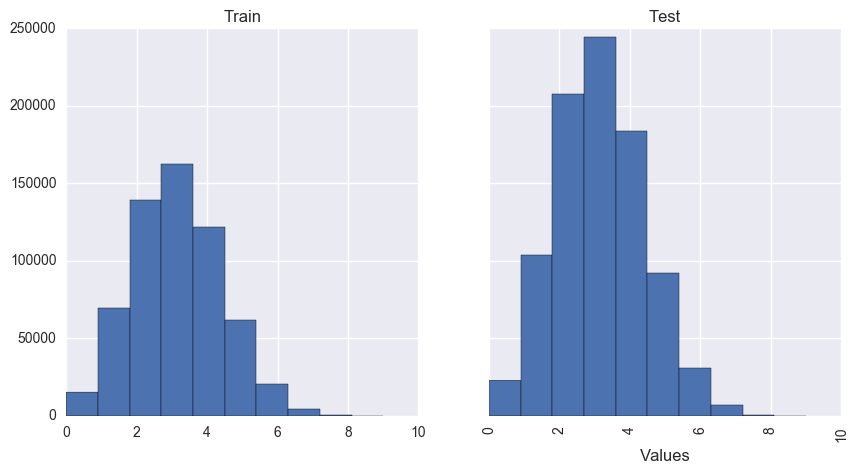

ps_calc_08


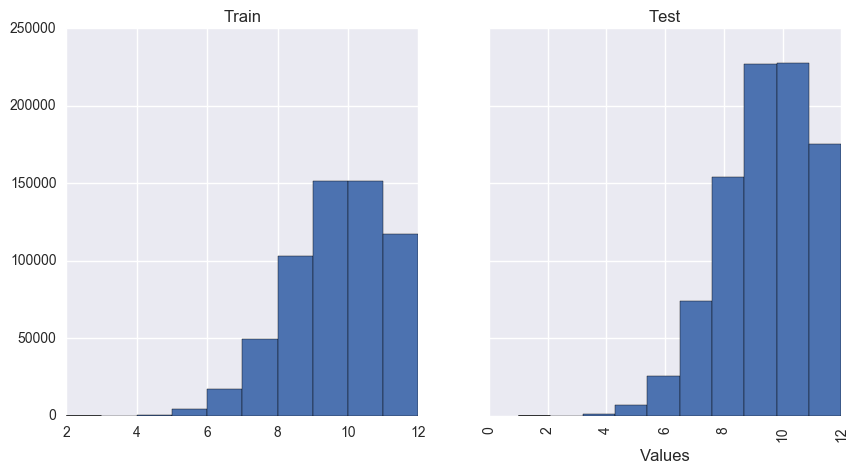

ps_calc_09


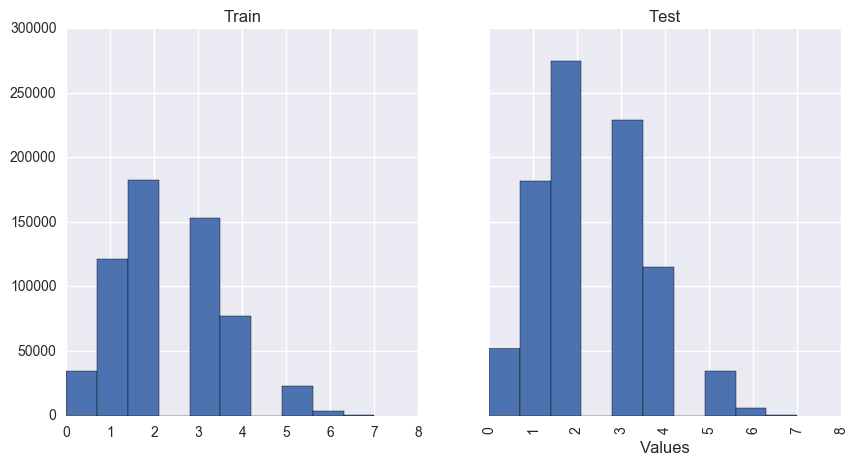

ps_calc_10


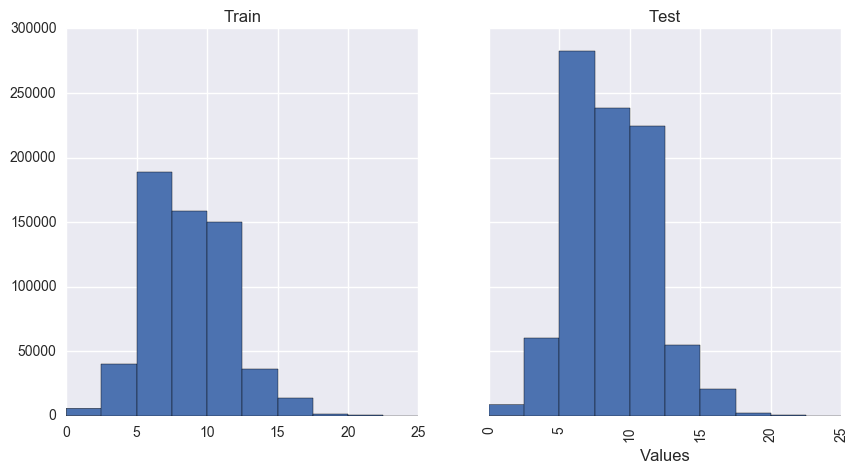

ps_calc_11


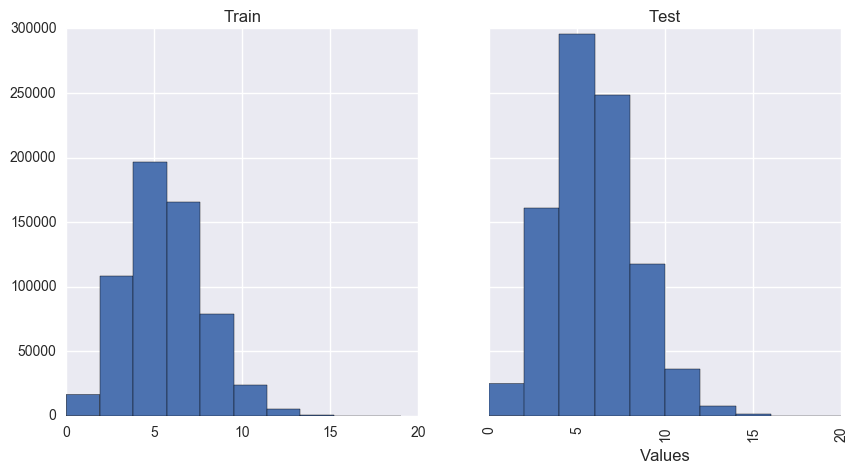

ps_calc_12


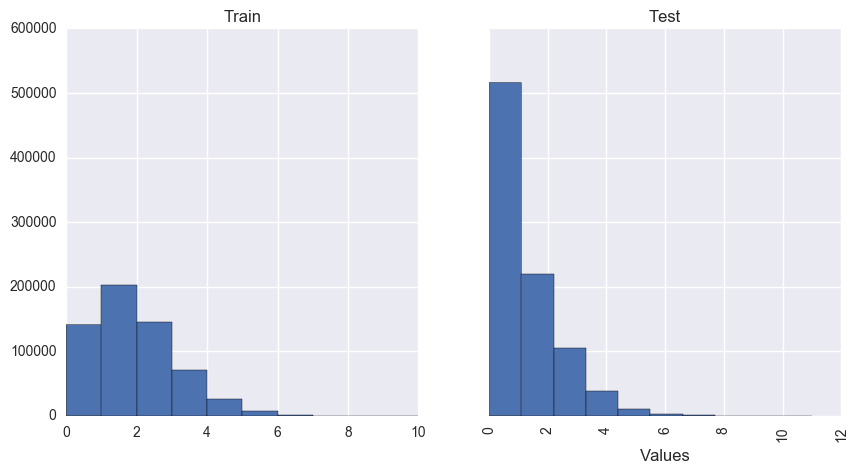

ps_calc_13


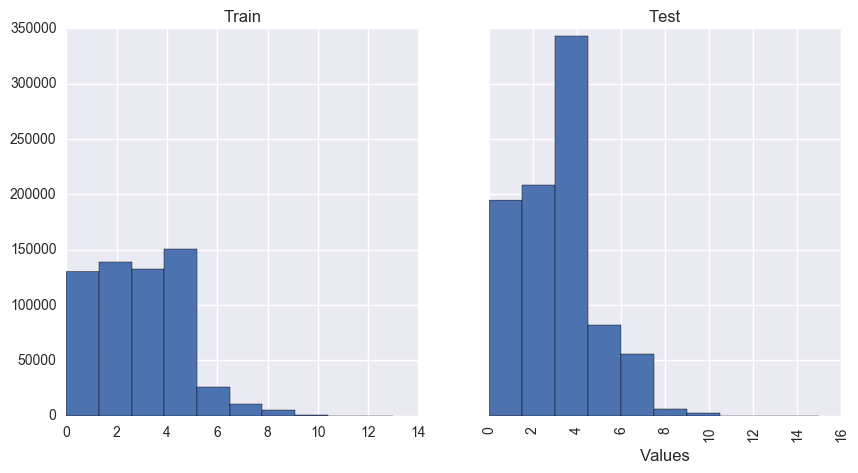

ps_calc_14


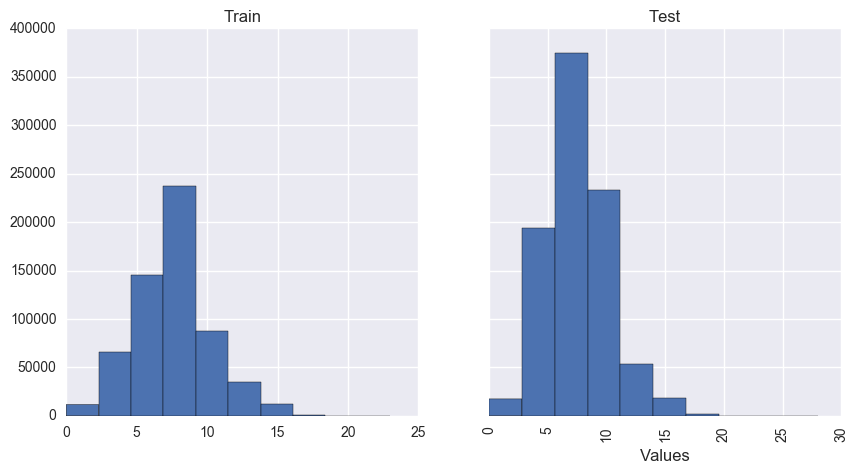

In [11]:
for c in other_features:
    if c in num_int:
        print(c)
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        df_train[c].hist(ax=ax1)
        df_test[c].hist(ax=ax2)
        ax1.set_title('Train')
        ax2.set_title('Test')
        plt.xlabel('Values', fontsize=12)
        plt.xticks(rotation='vertical')
        plt.show()

Now continuos features

ps_reg_01


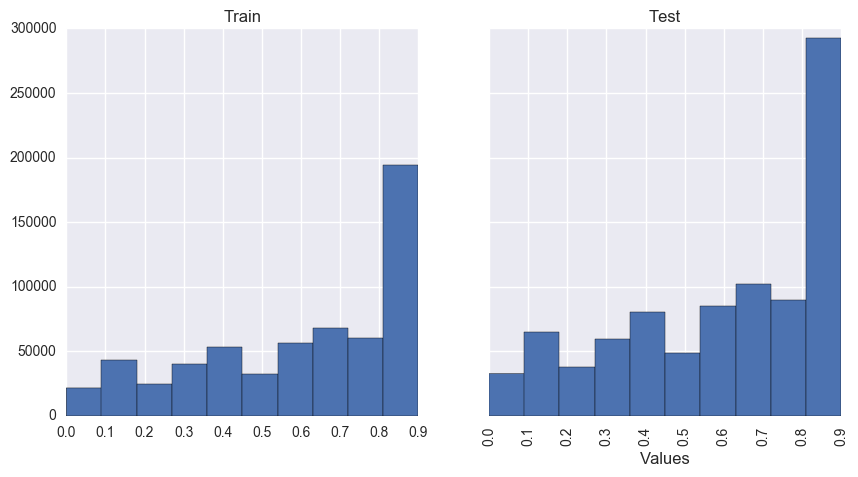

ps_reg_02


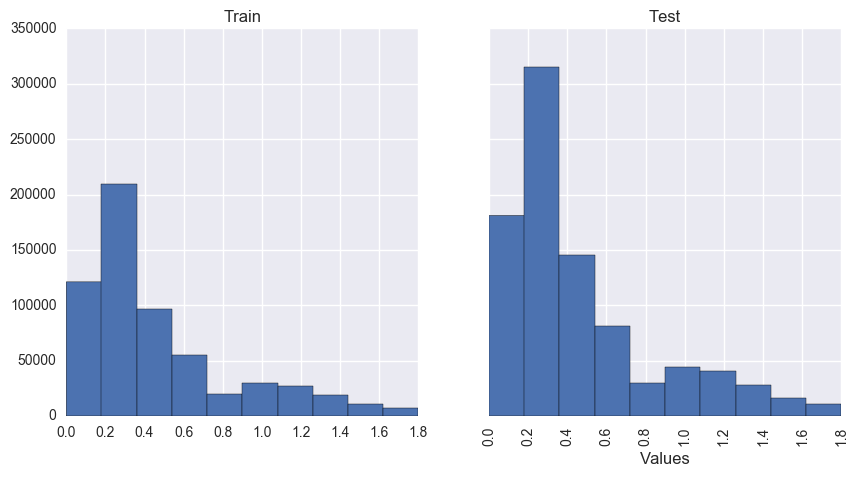

ps_reg_03


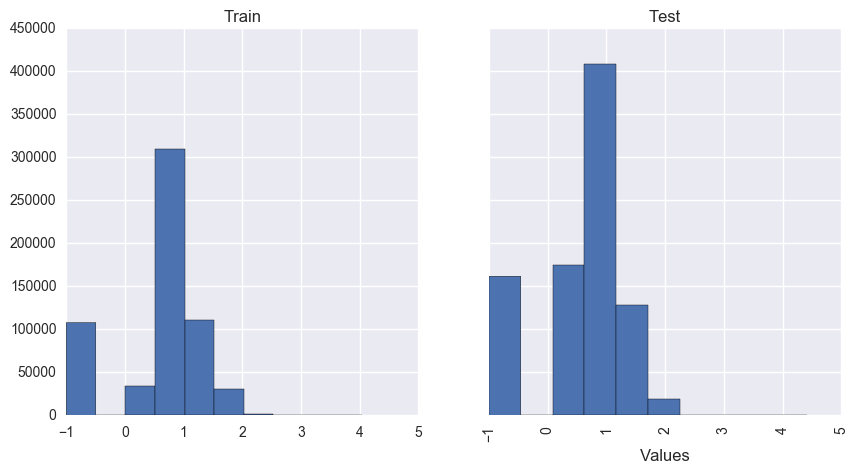

ps_car_12


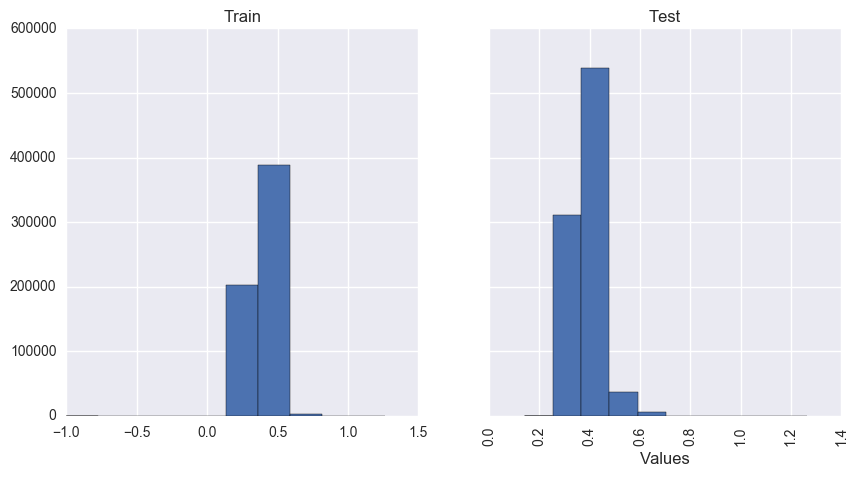

ps_car_13


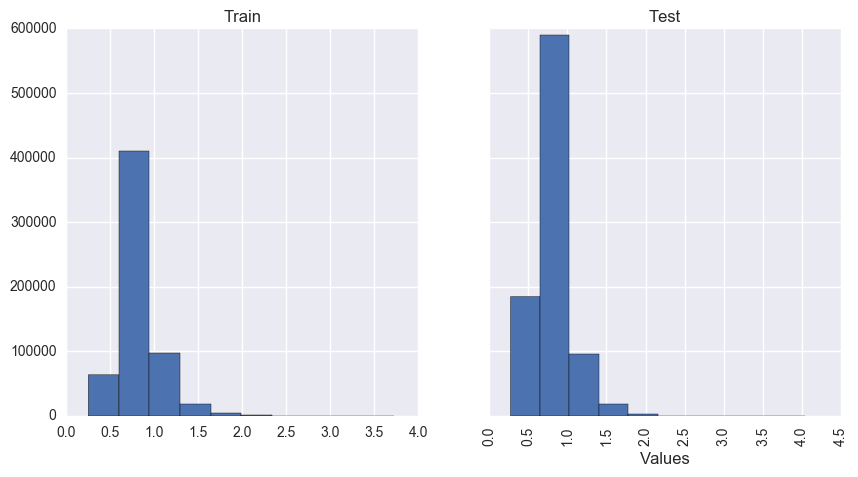

ps_car_14


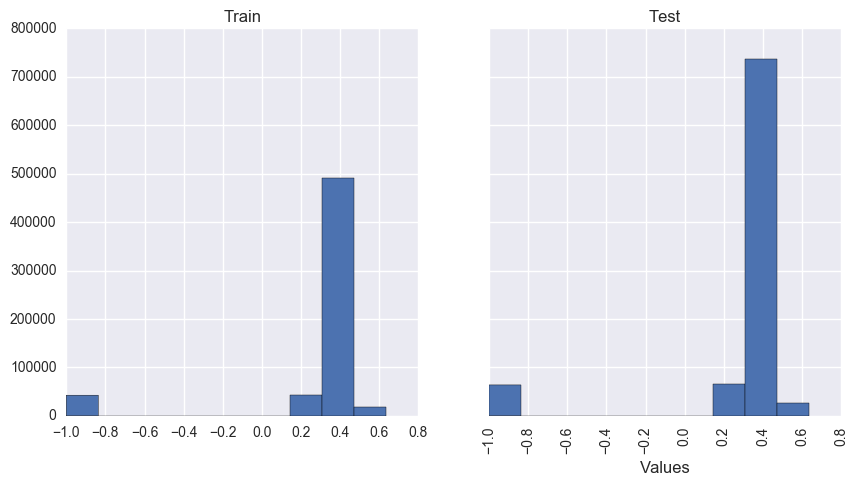

ps_car_15


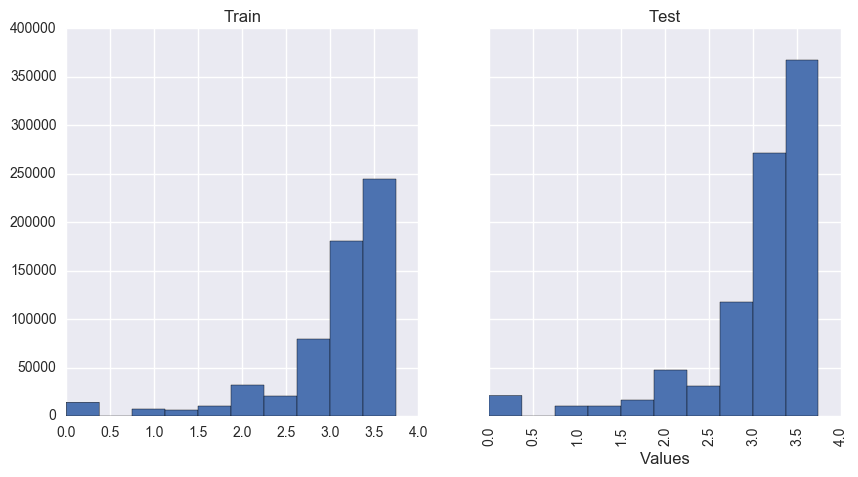

ps_calc_01


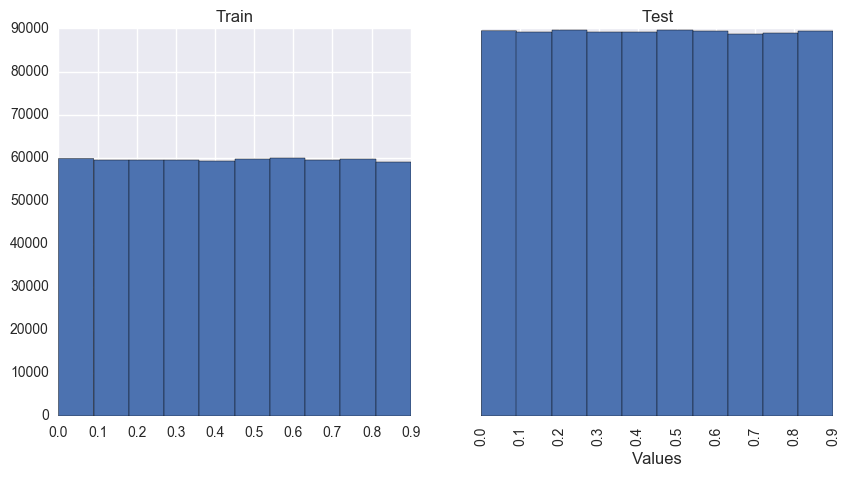

ps_calc_02


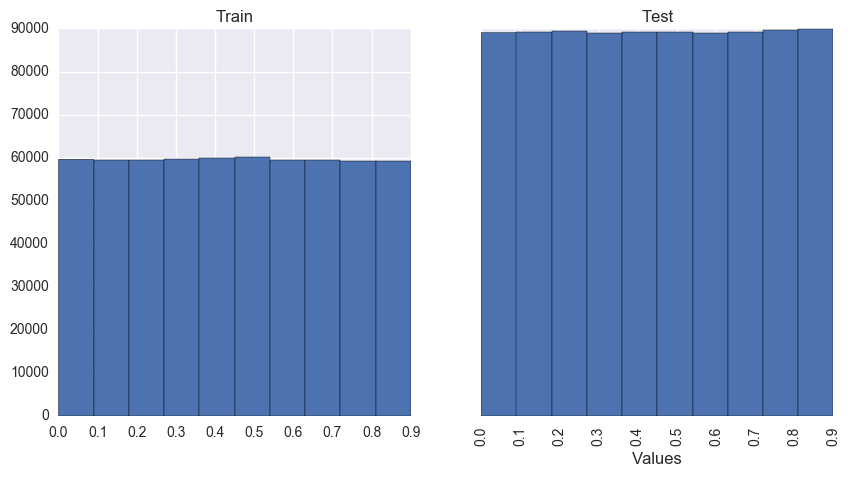

ps_calc_03


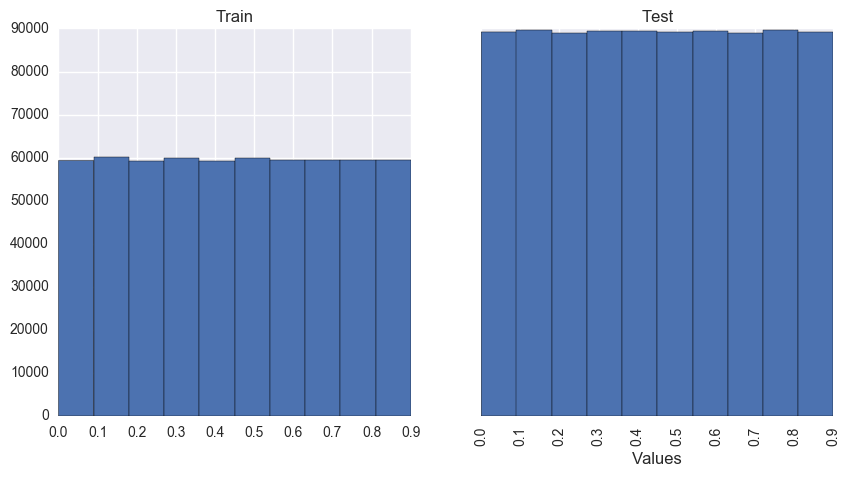

In [12]:
for c in other_features:
    if c in num_float:
        print(c)
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        df_train[c].hist(ax=ax1)
        df_test[c].hist(ax=ax2)
        ax1.set_title('Train')
        ax2.set_title('Test')
        plt.xlabel('Values', fontsize=12)
        plt.xticks(rotation='vertical')
        plt.show()

**Target variable**

C:\Program Files\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



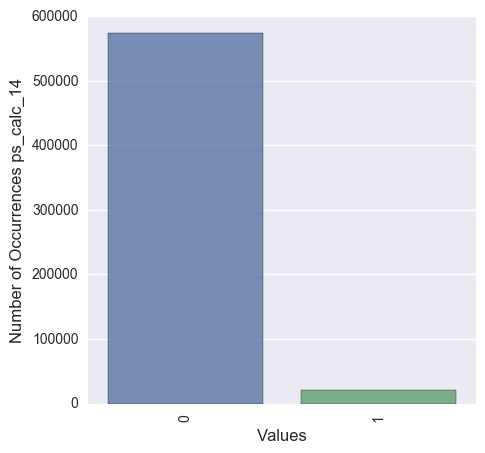

In [13]:
value_counts = df_train['target'].value_counts()
plt.figure(figsize=(5,5))
sns.barplot(value_counts.index, value_counts.values, alpha=0.8)
plt.ylabel('Number of Occurrences ' + c, fontsize=12)
plt.xlabel('Values', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Much more negative cases

In [14]:
from collections import Counter
Counter(df_train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

**Correlations**

In [15]:
#colormap = plt.cm.inferno
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(df_train[num_float].corr(),linewidths=0.1,vmax=1.0, square=True, linecolor='white', annot=True)

We see a high correlation between the different region features,.
There are also correlation between some car features:
[ps_car_12, ps_car_13], [ps_car_13, ps_car15]

**Correlation between integer features**

In [16]:

# colormap = plt.cm.bone
plt.figure(figsize=(21,16))
plt.title('Pearson correlation of categorical features', y=1.05, size=15)
sns.heatmap(df_train[num_int].corr(),linewidths=0.1,vmax=1.0, square=True, linecolor='white', annot=False)

In [17]:
#train_int = train_int.drop(["id", "target"], axis=1)
# colormap = plt.cm.bone
# plt.figure(figsize=(21,16))
# plt.title('Pearson correlation of categorical features', y=1.05, size=15)
# sns.heatmap(train_cat.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=False)
data = [
    go.Heatmap(
        z= df_train[num_int].corr().values,
        x=df_train[num_int].columns.values,
        y=df_train[num_int].columns.values,
        colorscale='Viridis',
        reversescale = False,
        text = True ,
        opacity = 1.0 )
]

layout = go.Layout(
    title='Pearson Correlation of Integer-type features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

There is correlation between some of the individual features

**Dimensionality reduction**

In [18]:
ignore_columns = ['target', 'id', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin'] + ['ps_calc_{:02d}'.format(i) for i in range(1, 15)] + ['ps_calc_{:02d}_bin'.format(i) for i in range(15, 21)]
train_columns = [col for col in df_train.columns if col not in ignore_columns]

In [19]:
X = df_train[train_columns].values
target = df_train.target
print("Training data shape: ", X.shape)

pca = PCA(n_components=2)
reduced_dim = pca.fit_transform(X)

Training data shape:  (595212, 33)


In [20]:
reduced_df = pd.DataFrame(data=reduced_dim, columns=['x', 'y'])
reduced_df['target'] = target


In [21]:
reduced_df.head()

,x,y,target
0,50.232290,-2.278322,0
1,43.196416,4.627109,0
2,2.202931,7.416517,0
3,-41.804101,4.049448,0
4,-19.819921,7.218939,0


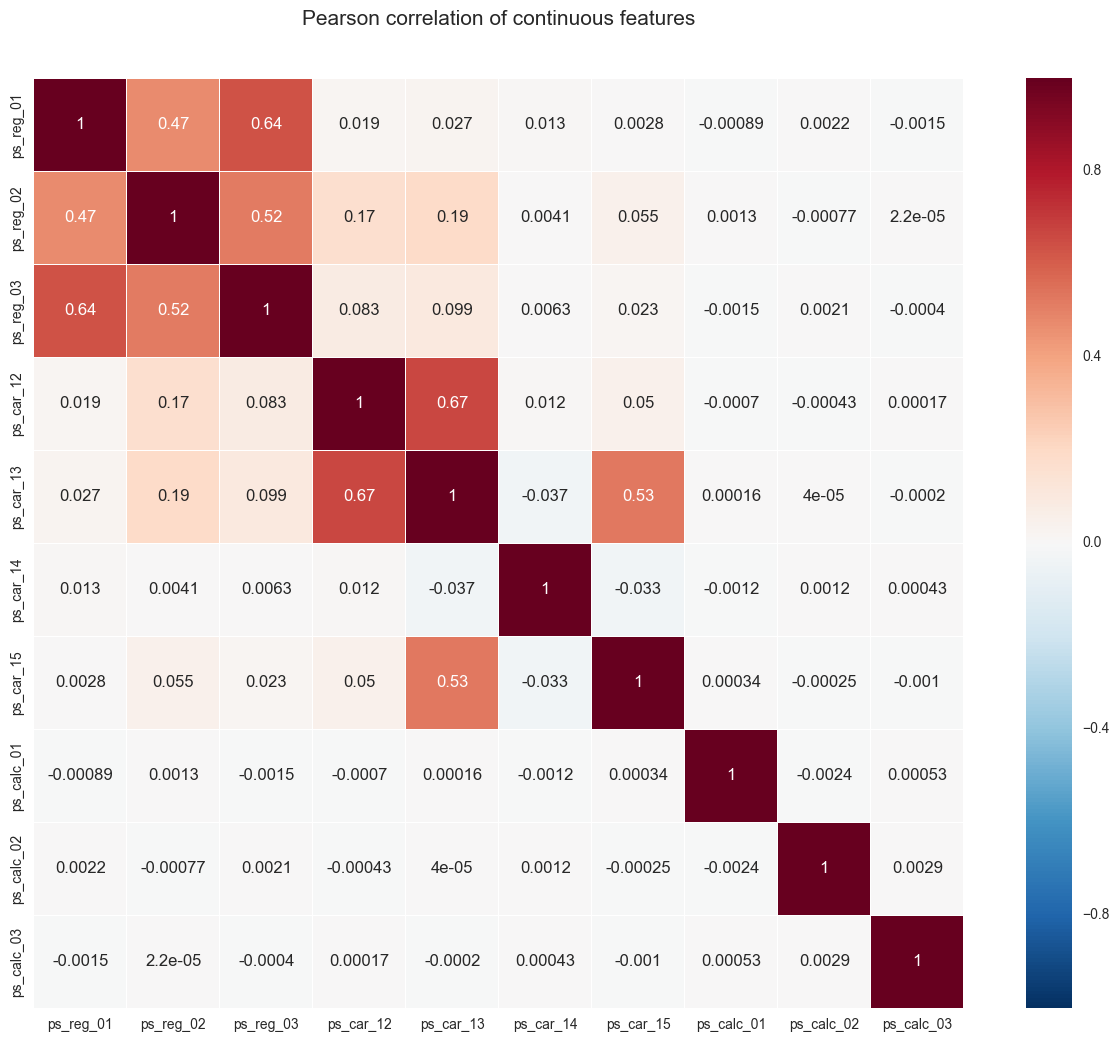

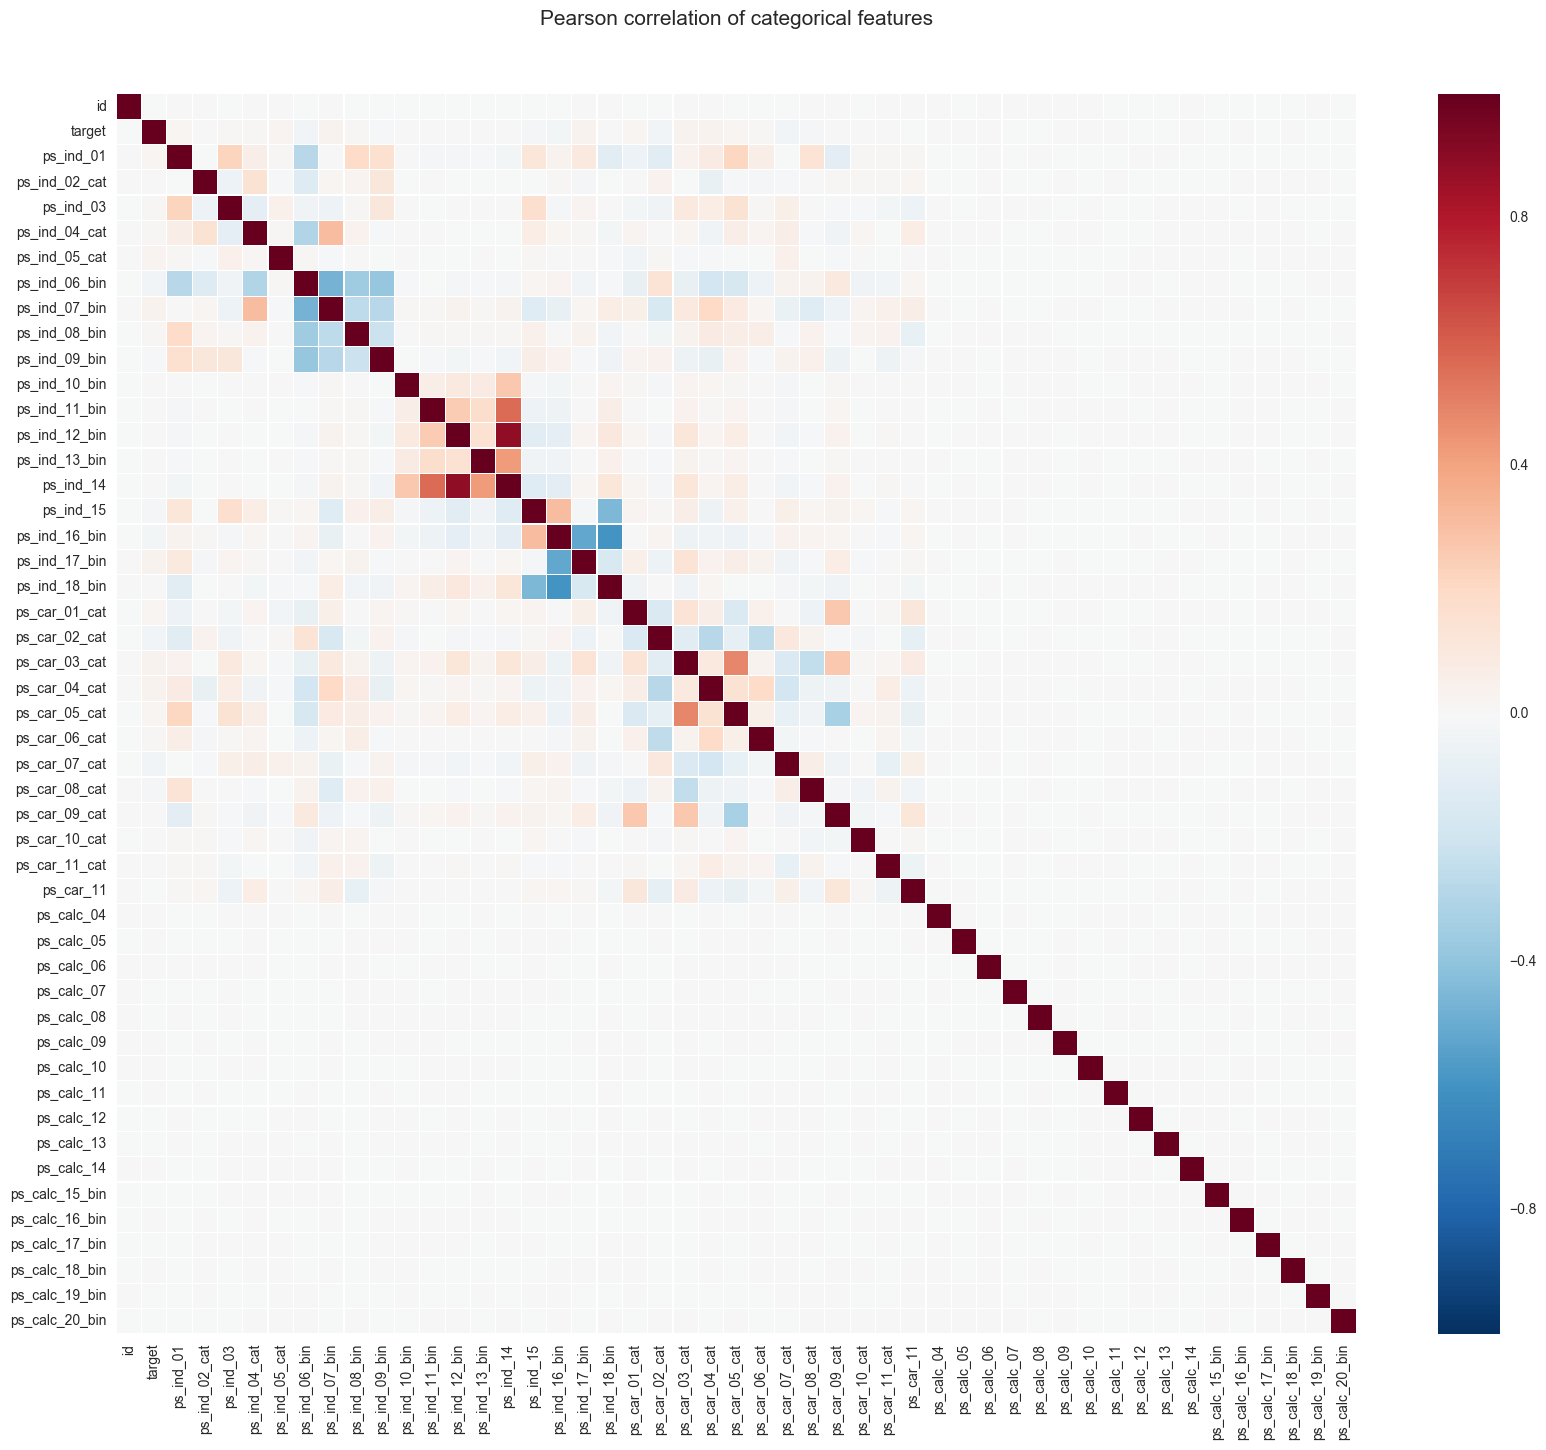

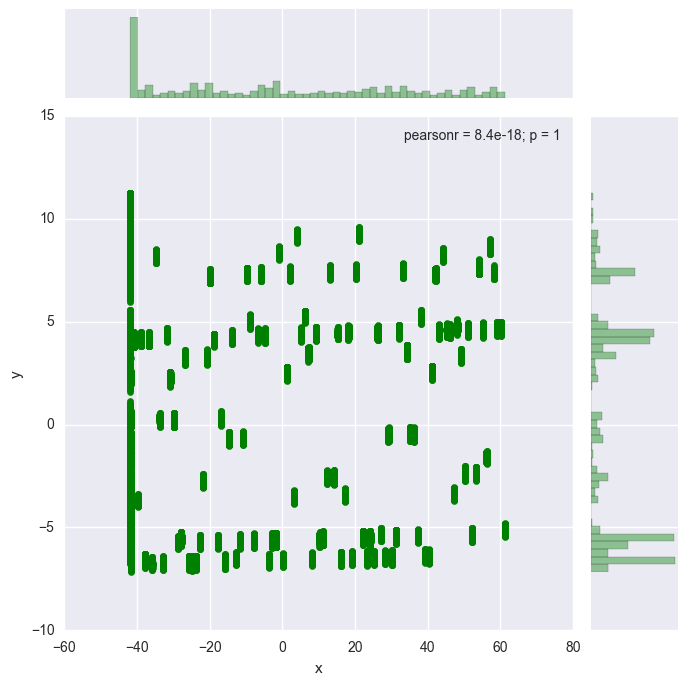

In [22]:
plt.figure(figsize=(20, 8))
sns.jointplot(x='x', y='y', data=reduced_df, size=7, color="g")
plt.show()

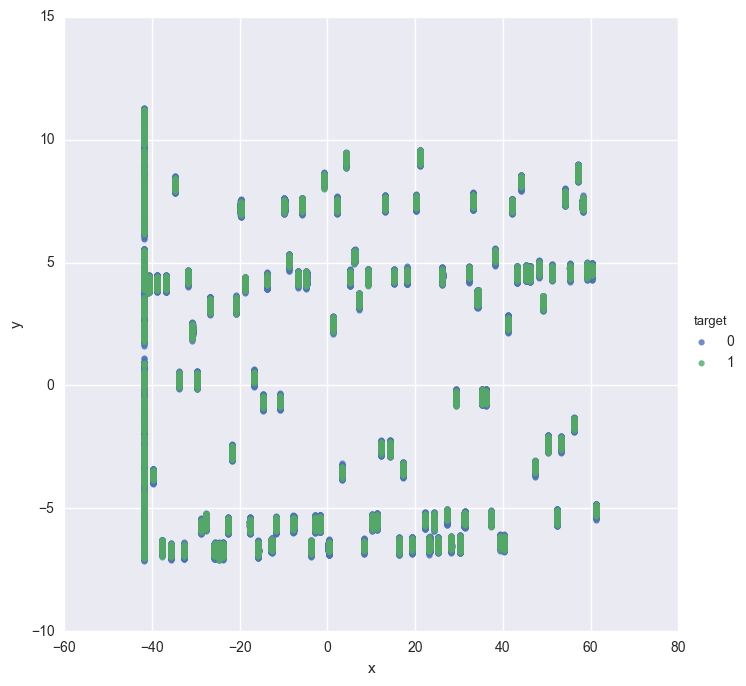

In [ ]:
plt.figure(figsize=(20,15))
sns.lmplot(x='x', y='y', hue='target', data=reduced_df, size=7, fit_reg=False)
plt.show()

In [ ]:
tsne = TSNE(n_components=2, random_state=17)
Y_tsn_all = tsne.fit_transform(X)
df_tsne = pd.DataFrame(data=reduced_dim, columns=['x', 'y'])
df_tsne['target'] = target

# Set style of scatterplot
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

# Create scatterplot of dataframe
sns.lmplot('x', # Horizontal axis
           'y', # Vertical axis
           data=df_tsne, # Data source
           fit_reg=False, # Don't fix a regression line
           hue="target", # Set color
           scatter_kws={"marker": "D", # Set marker style
                        "s": 100}) # S marker size



In [ ]:
sns.lmplot('x', 'y', data=df_tsne, hue='target', fit_reg=False)
plt.title('t-SNE')
plt.show()

> **Compute percentatge of target equals 1 for categorical features**

In [ ]:
for c in df_train.columns:
    if 'percentatge_true' in c:
        df_train.drop(c, axis=1, inplace=True)

In [ ]:
one_hot = {c: list(df_train[c].unique()) for c in df_train.columns if c not in ['id','target']}

for c in df_train.columns:
    if 'cat' in c:
        print(c)
        df_train[c+'_percentatge_true'] = np.zeros(len(df_train), np.float32)
        df_test[c+ '_percentatge_true'] = np.zeros(len(df_test), np.float32)
        for val in one_hot[c]:
            percent = len(df_train[(df_train.target == 1) & (df_train[c]==val)]) / len(df_train[df_train[c]==val])
            df_train.loc[df_train[c] == val, c + '_percentatge_true'] = percent
            df_test.loc[df_test[c] == val, c + '_percentatge_true'] = percent

In [ ]:
df_train['ps_car_06_cat_percentatge_true'].value_counts()

In [ ]:
df_test['ps_car_06_cat_percentatge_true'].value_counts()

**Feature ps_car_15**

In [ ]:
df_train['ps_car_15'].unique()